In [53]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from d2l import mxnet as d2l
from mxnet import gluon, np
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy import sparse
from scipy.sparse.linalg import norm
import random
import matplotlib.pyplot as plt
import time

In [54]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [55]:
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')


In [56]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [57]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [58]:
print (str(n_users) + ' users')
print (str(n_items) + ' items')
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print ('Sparsity: {:4.2f}%'.format(sparsity))

943 users
1682 items
Sparsity: 6.30%


In [59]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [60]:
train, test = train_test_split(ratings)

In [61]:
import math
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print ('\tcurrent iteration: {}'.format(ctr))
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_rmse : (list)
            Training data MSE values for each value of iter_array
        test_rmse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print ('Iteration: {}'.format(n_iter))
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_rmse += [(get_rmse(predictions, self.ratings))]
            self.test_rmse += [(get_rmse(predictions, test))]
            if self._v:
                print ('Train rmse: ' + str(self.train_rmse[-1]))
                print ('Test rmse: ' + str(self.test_rmse[-1]))
            iter_diff = n_iter

In [64]:
from sklearn.metrics import mean_squared_error

def get_rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [65]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train rmse: 1.0685871781261846
Test rmse: 1.0900974349210664
Iteration: 2
Train rmse: 1.0353367327518235
Test rmse: 1.0669329659003206
Iteration: 5
Train rmse: 0.9877036806419327
Test rmse: 1.0303952318126657
Iteration: 10
Train rmse: 0.9581260017898109
Test rmse: 1.0056191005142332
Iteration: 25
	current iteration: 10
Train rmse: 0.9307287656250898
Test rmse: 0.981595617940975
Iteration: 50
	current iteration: 10
	current iteration: 20
Train rmse: 0.915922473546946
Test rmse: 0.9709863977405273
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train rmse: 0.8694856766718736
Test rmse: 0.9605658815444347
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train rmse: 0.6361832772066001
Test rmse: 0.95466

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_rmse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_rmse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('RMSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

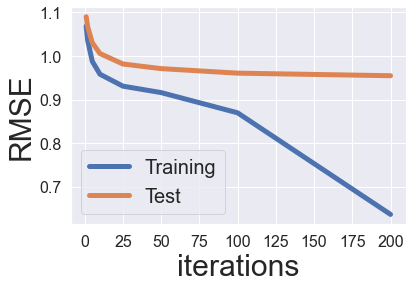

In [70]:
plot_learning_curve(iter_array, MF_SGD)

Optimizing SGD model parameters
Let’s try to optimize some hyperparameters. We’ll start with a grid search of the learning rate.

In [71]:

iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]

best_params = {}
best_params['learning_rate'] = None
best_params['n_iter'] = 0
best_params['train_Rmse'] = np.inf
best_params['test_Rmse'] = np.inf
best_params['model'] = None


for rate in learning_rates:
    print ('Rate: {}'.format(rate))
    MF_SGD = ExplicitMF(train, n_factors=40, learning='sgd')
    MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=rate)
    min_idx = np.argmin(MF_SGD.test_rmse)
    if MF_SGD.test_rmse[min_idx] < best_params['test_Rmse']:
        best_params['n_iter'] = iter_array[min_idx]
        best_params['learning_rate'] = rate
        best_params['train_Rmse'] = MF_SGD.train_rmse[min_idx]
        best_params['test_Rmse'] = MF_SGD.test_rmse[min_idx]
        best_params['model'] = MF_SGD
        print ('New optimal hyperparameters')
        print (pd.Series(best_params))


Rate: 1e-05
New optimal hyperparameters
learning_rate                                              0.00001
n_iter                                                         200
train_Rmse                                                1.035381
test_Rmse                                                 1.066976
model            <__main__.ExplicitMF object at 0x000001C480C60...
dtype: object
Rate: 0.0001
New optimal hyperparameters
learning_rate                                               0.0001
n_iter                                                         200
train_Rmse                                                0.936341
test_Rmse                                                 0.986497
model            <__main__.ExplicitMF object at 0x000001C4FCB62...
dtype: object
Rate: 0.001
New optimal hyperparameters
learning_rate                                                0.001
n_iter                                                         200
train_Rmse                                     

Looks like a learning rate of 0.001 was the best value. Note that the best test error was for only 100 iterations, not 200 — it’s likely that the model started to overfit after this point. On that note, we’ll now complete the hyperparameter optimization with a grid search through regularization terms and latent factors. This takes a while and could easily be parallelized, but that’s beyond the scope of this post.

In [72]:
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
latent_factors = [5, 10, 20, 40, 80]
regularizations = [0.001, 0.01, 0.1, 1.]
regularizations.sort()

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['train_Rmse'] = np.inf
best_params['test_Rmse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print ('Factors: {}'.format(fact))
    for reg in regularizations:
        print ('Regularization: {}'.format(reg))
        MF_SGD = ExplicitMF(train, n_factors=fact, learning='sgd',\
                            user_fact_reg=reg, item_fact_reg=reg, \
                            user_bias_reg=reg, item_bias_reg=reg)
        MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)
        min_idx = np.argmin(MF_SGD.test_rmse)
        if MF_SGD.test_rmse[min_idx] < best_params['test_Rmse']:
            best_params['n_factors'] = fact
            best_params['reg'] = reg
            best_params['n_iter'] = iter_array[min_idx]
            best_params['train_Rmse'] = MF_SGD.train_rmse[min_idx]
            best_params['test_Rmse'] = MF_SGD.test_rmse[min_idx]
            best_params['model'] = MF_SGD
            print ('New optimal hyperparameters')
            print (pd.Series(best_params))

Factors: 5
Regularization: 0.001
New optimal hyperparameters
n_factors                                                     5
reg                                                       0.001
n_iter                                                      100
train_Rmse                                             0.872826
test_Rmse                                              0.974628
model         <__main__.ExplicitMF object at 0x000001C480C74...
dtype: object
Regularization: 0.01
New optimal hyperparameters
n_factors                                                     5
reg                                                        0.01
n_iter                                                      100
train_Rmse                                             0.870572
test_Rmse                                              0.967629
model         <__main__.ExplicitMF object at 0x000001C4F865B...
dtype: object
Regularization: 0.1
New optimal hyperparameters
n_factors                                     

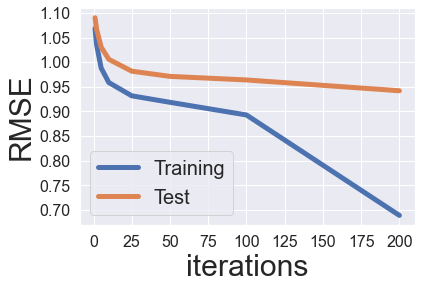

In [73]:
plot_learning_curve(iter_array, best_params['model'])

In [74]:
print ('Best regularization: {}'.format(best_params['reg']))
print ('Best latent factors: {}'.format(best_params['n_factors']))
print ('Best iterations: {}'.format(best_params['n_iter']))

Best regularization: 0.01
Best latent factors: 80
Best iterations: 200
